In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "True"
import tensorflow as tf
print("TensorFlow versión:", tf.__version__)
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))


TensorFlow versión: 2.10.1
GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, Embedding, Reshape, Flatten, Dropout, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LayerNormalization, Add, Multiply,GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

## Cargar datasets

In [3]:
df = pd.read_csv("Data_completa_enrriquecida.csv")  
df_audio_features = pd.read_csv("features_audio_quoted.csv")

In [4]:
df_audio_features.shape

(4107, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24966 entries, 0 to 24965
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Letra                   24966 non-null  object 
 1   Idioma                  24848 non-null  object 
 2   lyrics_state            24966 non-null  object 
 3   hasLetra                24966 non-null  float64
 4   Lyrics                  24966 non-null  object 
 5   Lyrics_proces           24966 non-null  object 
 6   songId                  24966 non-null  object 
 7   track_uri               24966 non-null  object 
 8   track_name              24966 non-null  object 
 9   artist_uri              24966 non-null  object 
 10  artist_info             24966 non-null  object 
 11  artist_name             24966 non-null  object 
 12  artist_pop              24966 non-null  float64
 13  album                   24964 non-null  object 
 14  track_pop               24966 non-null

In [6]:
df_audio_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4107 entries, 0 to 4106
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   song_id                  4107 non-null   object 
 1   tempo_librosa            4107 non-null   float64
 2   chroma_stft_beat         4107 non-null   object 
 3   chroma_cqt_beat          4107 non-null   object 
 4   melspectrogram_beat      4107 non-null   object 
 5   mfcc_beat                4107 non-null   object 
 6   mfcc_delta_beat          4107 non-null   object 
 7   rms_beat                 4107 non-null   object 
 8   spectral_centroid_beat   4107 non-null   object 
 9   spectral_bandwidth_beat  4107 non-null   object 
 10  spectral_contrast_beat   4107 non-null   object 
 11  spectral_flatness_beat   4107 non-null   object 
 12  spectral_rolloff_beat    4107 non-null   object 
 13  tonnetz_beat             4107 non-null   object 
 14  zero_crossing_rate_beat 

In [7]:
df_audio_features.head()

,song_id,tempo_librosa,chroma_stft_beat,chroma_cqt_beat,melspectrogram_beat,mfcc_beat,mfcc_delta_beat,rms_beat,spectral_centroid_beat,spectral_bandwidth_beat,spectral_contrast_beat,spectral_flatness_beat,spectral_rolloff_beat,tonnetz_beat,zero_crossing_rate_beat
0,dead-to-rights-spetsnaz,175.781250,"[[0.6412995457649231, 0.6017413139343262, 0.62...","[[0.7070590257644653, 0.5353679060935974, 0.63...","[[0.031194493174552917, 0.10795113444328308, 0...","[[-316.5719909667969, 148.6926727294922, -7.90...","[[3.318288564682007, 2.173276901245117, 0.1416...","[[0.02098485454916954], [0.05658692494034767],...","[[1508.1806029447166], [1569.4689252697785], [...","[[1514.028219317217], [1593.703720592881], [21...","[[16.17854614094429, 7.762626037724977, 10.736...","[[4.530391743173823e-05], [2.74423055088846e-0...","[[2488.415948275862], [2840.7866379310344], [4...","[[0.0029363415994891015, 0.005052085877211278,...","[[0.0412176724137931], [0.046319369612068964],..."
1,bedroom-floor-racoon,95.338983,"[[0.24465931951999664, 0.16433988511562347, 0....","[[0.2490415722131729, 0.13250912725925446, 0.3...","[[0.0010919551132246852, 0.028914380818605423,...","[[-394.5964660644531, 114.07601165771484, 39.6...","[[0.2844964265823364, 0.10858345031738281, -0....","[[0.047222498804330826], [0.1502489447593689],...","[[1074.0177560523468], [973.6199151091207], [1...","[[1735.8049073997722], [1611.775363210558], [1...","[[19.514700370597453, 18.341881542521566, 20.9...","[[0.04371122270822525], [6.570429377461551e-06...","[[1464.0688580874873], [2037.8707627118645], [...","[[0.009217212979134195, 0.1725632330172083, 0....","[[0.028936748950915563], [0.011313228283898306..."
2,one-dance-dan-bern,117.187500,"[[0.6580115556716919, 0.7883133888244629, 0.90...","[[0.1832597553730011, 0.24094854295253754, 0.3...","[[1901.0926513671875, 2173.593017578125, 534.2...","[[-141.47274780273438, 107.6637954711914, 10.4...","[[0.8265359997749329, -1.8435794115066528, -0....","[[0.4414933919906616], [0.18002480268478394], ...","[[2560.5617676539214], [2245.246704137298], [1...","[[4078.160662772188], [3253.1277167506846], [2...","[[19.569047568026605, 10.633053265942879, 18.6...","[[0.00023297860752791166], [0.0008921041153371...","[[6219.84375], [4586.42578125], [2959.41310975...","[[0.12549380823324546, 0.1778435763416696, 0.2...","[[0.0125390625], [0.030131022135416668], [0.02..."
3,mcdahmers-macabre,95.338983,"[[0.6931225061416626, 0.7375596165657043, 0.63...","[[0.25509577989578247, 0.29439759254455566, 0....","[[237.8543243408203, 550.334716796875, 226.864...","[[-244.58859252929688, 176.52969360351562, 26....","[[0.1807635873556137, -0.06337742507457733, -0...","[[0.20762179791927338], [0.16544213891029358],...","[[952.7026141635262], [3760.6400756399394], [2...","[[1698.2393153508854], [4127.976776328313], [3...","[[16.850521639391264, 12.926260956614653, 16.3...","[[0.00010144334373762831], [0.0020864554680883...","[[1765.858208955224], [7914.327330508475], [61...","[[-0.16473157134588107, 0.09589412075176701, -...","[[0.01277450637437811], [0.0789112155720339], ..."
4,madame-ray-long-blondes,175.781250,"[[0.6412995457649231, 0.6017413139343262, 0.62...","[[0.7070590257644653, 0.5353679060935974, 0.63...","[[0.031194493174552917, 0.10795113444328308, 0...","[[-316.5719909667969, 148.6926727294922, -7.90...","[[3.318288564682007, 2.173276901245117, 0.1416...","[[0.02098485454916954], [0.05658692494034767],...","[[1508.1806029447166], [1569.4689252697785], [...","[[1514.028219317217], [1593.703720592881], [21...","[[16.17854614094429, 7.762626037724977, 10.736...","[[4.530391743173823e-05], [2.74423055088846e-0...","[[2488.415948275862], [2840.7866379310344], [4...","[[0.0029363415994891015, 0.005052085877211278,...","[[0.0412176724137931], [0.046319369612068964],..."


In [8]:
print(repr(df_audio_features.loc[0, 'melspectrogram_beat']))

'[[0.031194493174552917, 0.10795113444328308, 0.17013601958751678, 0.12288825958967209, 0.13897475600242615, 0.26561376452445984, 0.3826806843280792, 0.35467299818992615, 0.5297439694404602, 0.5733678340911865, 0.40801751613616943, 0.5498940944671631, 0.37446555495262146, 0.4276750683784485, 0.5950906872749329, 0.5263879299163818, 0.36640942096710205, 0.3226248621940613, 0.3064301609992981, 0.2806263267993927, 0.3074745237827301, 0.1995716392993927, 0.09885618835687637, 0.09178564697504044, 0.13543853163719177, 0.10148510336875916, 0.11061336100101471, 0.08693519234657288, 0.16046729683876038, 0.2252437323331833, 0.2551293671131134, 0.2739996612071991, 0.19940489530563354, 0.07497205585241318, 0.06690830737352371, 0.0691574215888977, 0.03954874724149704, 0.020815929397940636, 0.04242730140686035, 0.13185103237628937, 0.10150187462568283, 0.1939275860786438, 0.20580504834651947, 0.16308848559856415, 0.20600004494190216, 0.16144953668117523, 0.08137952536344528, 0.05658629909157753, 0.03

## Ver duplicados datasets

In [9]:
print("Número de songIds únicos en df:", df['songId'].nunique())
print("Número de songIds únicos en df_audio_features:", df_audio_features['song_id'].nunique())

Número de songIds únicos en df: 24026
Número de songIds únicos en df_audio_features: 4107


In [10]:

song_id_counts = df['songId'].value_counts()

duplicated_song_ids = song_id_counts[song_id_counts > 1].index

df[df['songId'].isin(duplicated_song_ids)].head(10)


,Letra,Idioma,lyrics_state,hasLetra,Lyrics,Lyrics_proces,songId,track_uri,track_name,artist_uri,...,dominance_tags,mbid,spotify_id,genre,cuadrante,cuadReal,lexicones,emociones,emocionesLetra,emocion_mas_comun
28,Data/Letras/45-Hush-Hush;-Hush-Hush-The-Pussyc...,en,complete,1.0,Hush Hush; Hush Hush Lyrics[Intro: Nicole Sche...,oohoohooh ohoh yeah oohooh needed strong neede...,hush-hush;-hush-hush-pussycat-dolls.txt,spotify:track:2H9CKpZiLDF223BbwehpDF,Hush Hush; Hush Hush - Main,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,...,6.241222,ec352164-18e9-4b52-881d-99442b9f9f41,2H9CKpZiLDF223BbwehpDF,pop,3,1,[0. 3. 0. 0. 0. 3. 2. 0. 0. 0.],"['anticipation', 'negative', 'positive']","['3', '2', '1']",3
29,Data/Letras/45-Hush-Hush;-Hush-Hush-The-Pussyc...,en,complete,1.0,Hush Hush; Hush Hush Lyrics[Intro: Nicole Sche...,oohoohooh ohoh yeah oohooh needed strong neede...,hush-hush;-hush-hush-pussycat-dolls.txt,spotify:track:2H9CKpZiLDF223BbwehpDF,Hush Hush; Hush Hush - Main,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,...,4.708958,d86b4684-5222-44d9-91de-62fd397e524e,2H9CKpZiLDF223BbwehpDF,pop,0,1,[0. 3. 0. 0. 0. 3. 2. 0. 0. 0.],"['anticipation', 'negative', 'positive']","['3', '2', '1']",3
30,Data/Letras/45-Hush-Hush;-Hush-Hush-The-Pussyc...,en,complete,1.0,Hush Hush; Hush Hush Lyrics[Intro: Nicole Sche...,oohoohooh ohoh yeah oohooh needed strong neede...,hush-hush;-hush-hush-pussycat-dolls.txt,spotify:track:2H9CKpZiLDF223BbwehpDF,Hush Hush; Hush Hush - Main,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,...,6.241222,ec352164-18e9-4b52-881d-99442b9f9f41,2H9CKpZiLDF223BbwehpDF,pop,3,1,[0. 3. 0. 0. 0. 3. 2. 0. 0. 0.],"['anticipation', 'negative', 'positive']","['3', '2', '1']",3
31,Data/Letras/45-Hush-Hush;-Hush-Hush-The-Pussyc...,en,complete,1.0,Hush Hush; Hush Hush Lyrics[Intro: Nicole Sche...,oohoohooh ohoh yeah oohooh needed strong neede...,hush-hush;-hush-hush-pussycat-dolls.txt,spotify:track:2H9CKpZiLDF223BbwehpDF,Hush Hush; Hush Hush - Main,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,...,4.708958,d86b4684-5222-44d9-91de-62fd397e524e,2H9CKpZiLDF223BbwehpDF,pop,0,1,[0. 3. 0. 0. 0. 3. 2. 0. 0. 0.],"['anticipation', 'negative', 'positive']","['3', '2', '1']",3
205,Data/Letras/360-A-Better-Son-Daughter-Rilo-Kil...,en,complete,1.0,A Better Son/Daughter Lyrics[Verse 1]\nSometim...,morning petrified awake open eyes weight crush...,a-better-son-daughter-rilo-kiley.txt,spotify:track:71sC9gVXaFRwAMHJyQO8al,A Better Son/Daughter,spotify:artist:2cevwbv7ISD92VMNLYLHZA,...,5.017783,f2e8cdfe-2b1e-4cc4-810e-2b675f438039,71sC9gVXaFRwAMHJyQO8al,indie,3,3,[0. 0. 0. 0. 0. 0. 2. 0. 0. 2.],"['positive', 'trust']","['1', '3']",1
206,Data/Letras/360-A-Better-Son-Daughter-Rilo-Kil...,en,complete,1.0,A Better Son/Daughter Lyrics[Verse 1]\nSometim...,morning petrified awake open eyes weight crush...,a-better-son-daughter-rilo-kiley.txt,spotify:track:71sC9gVXaFRwAMHJyQO8al,A Better Son/Daughter,spotify:artist:2cevwbv7ISD92VMNLYLHZA,...,5.345153,NaN,71sC9gVXaFRwAMHJyQO8al,indie,0,3,[0. 0. 0. 0. 0. 0. 2. 0. 0. 2.],"['positive', 'trust']","['1', '3']",1
207,Data/Letras/360-A-Better-Son-Daughter-Rilo-Kil...,en,complete,1.0,A Better Son/Daughter Lyrics[Verse 1]\nSometim...,morning petrified awake open eyes weight crush...,a-better-son-daughter-rilo-kiley.txt,spotify:track:71sC9gVXaFRwAMHJyQO8al,A Better Son/Daughter,spotify:artist:2cevwbv7ISD92VMNLYLHZA,...,5.017783,f2e8cdfe-2b1e-4cc4-810e-2b675f438039,71sC9gVXaFRwAMHJyQO8al,indie,3,3,[0. 0. 0. 0. 0. 0. 2. 0. 0. 2.],"['positive', 'trust']","['1', '3']",1
208,Data/Letras/360-A-Better-Son-Daughter-Rilo-Kil...,en,complete,1.0,A Better Son/Daughter Lyrics[Verse 1]\nSometim...,morning petrified awake open eyes weight crush...,a-better-son-daughter-rilo-kiley.txt,spotify:track:71sC9gVXaFRwAMHJyQO8al,A Better Son/Daughter,spotify:artist:2cevwbv7ISD92VMNLYLHZA,...,5.345153,NaN,71sC9gVXaFRwAMHJyQO8al,indie,0,3,[0. 0. 0. 0. 0. 0. 2. 0. 0. 2.],"['positive', 'trust']","['1', '3']",1
209,Data/Letras/9612-A-Better-Son-Daughter-Rilo-Ki...,en,complete,1.0,A B

## Revisar correlación entre variables

In [11]:
numeric_cols = ["number_of_emotion_tags","valence_tags","arousal_tags", "danceability", "tempo", "loudness","key","mode","speechiness","acousticness","instrumentalness",
"liveness",'track_pop',"valence","energy"]


In [12]:
df["cuadrante"] = df["cuadrante"].astype(float)

# 1) Forma rápida: corrwith
df[numeric_cols].corrwith(df["cuadrante"], method='pearson')

number_of_emotion_tags    0.112469
valence_tags             -0.048990
arousal_tags             -0.100555
danceability             -0.055127
tempo                    -0.003069
loudness                 -0.025842
key                      -0.003165
mode                      0.023339
speechiness              -0.032538
acousticness              0.058163
instrumentalness         -0.000777
liveness                 -0.023983
track_pop                 0.064385
valence                  -0.072638
energy                   -0.061329
dtype: float64

In [13]:
numeric_cols = [
    'danceability', 'loudness', 'acousticness'
]

In [14]:
X_num = df[numeric_cols].values

In [15]:
X_num[:5]

array([[ 5.480e-01, -3.237e+00,  6.220e-02],
       [ 2.490e-01, -2.642e+00,  1.310e-03],
       [ 6.680e-01, -4.226e+00,  1.090e-01],
       [ 8.050e-01, -4.554e+00,  4.930e-02],
       [ 6.570e-01, -3.524e+00,  1.690e-03]])

In [16]:
df['emocion_mas_comun'].value_counts()

emocion_mas_comun
3    11221
2     8133
1     5579
4       33
Name: count, dtype: int64

In [17]:
import pandas as pd
from scipy.stats import chi2_contingency

ct = pd.crosstab(df["emocion_mas_comun"], df["cuadrante"])
print(ct)

chi2, pval, dof, expected = chi2_contingency(ct)
print("Chi2 =", chi2, "p-value =", pval)

cuadrante           0.0   1.0   2.0   3.0   4.0
emocion_mas_comun                              
1                  2489  1090   784   561   655
2                  3925  1437  1099   973   699
3                  5169  2192  1544  1156  1160
4                    16     5     9     3     0
Chi2 = 78.50299847359224 p-value = 7.95850972616475e-12


In [18]:
df['emocion_mas_comun'].value_counts()

emocion_mas_comun
3    11221
2     8133
1     5579
4       33
Name: count, dtype: int64

## Consolidar dataset
- Manejar duplicados de songId

In [19]:
def single_or_mode(series):
    """
    Si la columna tiene exactamente un único valor en el grupo, lo devuelve.
    De lo contrario, devuelve la moda (el valor más frecuente).
    En caso de no existir valor definido, devuelve None.
    """
    # Eliminamos NaN para evitar que interfieran
    sin_nan = series.dropna()
    
    # Valores únicos
    unique_vals = sin_nan.unique()
    
    if len(unique_vals) == 1:
        # Si hay un único valor, lo devolvemos
        return unique_vals[0]
    else:
        # Si hay más de un valor, calculamos la moda
        modos = sin_nan.mode()
        if len(modos) > 0:
            return modos.iloc[0]
        else:
            # Si no hay modo (puede estar vacío), retornamos None
            return None


In [20]:
# Función para manejar duplicados de songId
def consolidate_group(group):
    return pd.Series({
        'Idioma': single_or_mode(group['Idioma']),
        'lyrics_state': single_or_mode(group['lyrics_state']),
        'track_name':single_or_mode(group['track_name']),
        'artist_uri':single_or_mode(group['artist_uri']),
        'hasLetra': group['hasLetra'].max(),
        'Lyrics': max(group['Lyrics'], key=len),
        'Lyrics_proces': max(group['Lyrics_proces'], key=len),
        'track_uri': single_or_mode(group['track_uri']),
        'valence': single_or_mode(group['valence']),
        'energy': single_or_mode(group['energy']),
        'danceability':single_or_mode(group['danceability']), 
        'loudness':single_or_mode(group['loudness']), 
        'acousticness':single_or_mode(group['acousticness']),
        'valence_tags': single_or_mode(group['valence_tags']),
        'arousal_tags': single_or_mode(group['arousal_tags']),
        'dominance_tags': single_or_mode(group['dominance_tags']),
        'number_of_emotion_tags': single_or_mode(group['number_of_emotion_tags']),
        'emocion_mas_comun': single_or_mode(group['emocion_mas_comun']),
        'cuadrante': single_or_mode(group['cuadrante']),
        'cuadReal': single_or_mode(group['cuadReal'])
    })

In [21]:
df = df.groupby('songId').apply(consolidate_group).reset_index()
print("Número de songIds únicos después de consolidar:", df['songId'].nunique())

Número de songIds únicos después de consolidar: 24026


C:\Users\andre\AppData\Local\Temp\ipykernel_9812\4204315383.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('songId').apply(consolidate_group).reset_index()


In [22]:
df.shape

(24026, 21)

In [23]:
df_audio_features.shape

(4107, 15)

In [24]:
df.head(5)

,songId,Idioma,lyrics_state,track_name,artist_uri,hasLetra,Lyrics,Lyrics_proces,track_uri,valence,...,danceability,loudness,acousticness,valence_tags,arousal_tags,dominance_tags,number_of_emotion_tags,emocion_mas_comun,cuadrante,cuadReal
0,"""boy-next-door""-its-my-party.txt",en,complete,"""The Boy Next Door""",spotify:artist:3mYd6hxK1vk6puzhSp0X3D,1.0,8 ContributorsMake Noize Lyrics[Intro: Kid]\nT...,duos effect house party set catching wreck mic...,spotify:track:17CW8CsTByrCWb58btMkSX,0.9650,...,0.665,-5.873,0.71200,0.674101,0.121831,5.920000,1,1,1.0,1
1,"""light-mass-prayers""-porcupine-tree.txt",en,complete,"""Light Mass Prayers""",spotify:artist:5NXHXK6hOCotCF8lvGM1I0,1.0,1 ContributorThe Laws Of Manu LyricsCHAPTER I....,chapter great sages approached manu seated col...,spotify:track:7IlzPutBp5cHQ2KTYWDnac,0.0258,...,0.115,-29.682,0.93600,0.079454,-0.284817,4.928684,2,2,0.0,3
2,"""you-got-a-killer-scene-there,-man""-queens-of-...",en,complete,"""You Got A Killer Scene There, Man...""",spotify:artist:4pejUc4iciQfgdX6OKulQn,1.0,"10 Contributors“You Got A Killer Scene There, ...",mean obscene mob know hell mean knot tight bli...,spotify:track:6ZZiYOTFuZC1XLJjMiEnvS,0.4360,...,0.546,-5.674,0.00572,-0.173888,-0.402321,5.316438,7,3,0.0,2
3,#1-animal-collective.txt,en,complete,#1,spotify:artist:4kwxTgCKMipBKhSnEstNKj,1.0,"#1 LyricsNoah: Mine, I want\nI caught you when...",noah want caught line got disconnected trouble...,spotify:track:6YZb2ESI1nvM2puafFrT7q,0.6780,...,0.412,-7.075,0.85500,0.653364,-0.007351,5.585454,7,1,0.0,1
4,#1-must-have-sleater-kinney.txt,en,complete,#1 Must Have,spotify:artist:4wLIbcoqmqI4WZHDiBxeCB,1.0,#1 Must Have Lyrics[Verse 1]\nBearer of the fl...,bearer flag beginning believed riot girls cyni...,spotify:track:1GZou2dcibn0E0Y6mbONsj,0.9370,...,0.595,-4.055,0.06060,-0.114516,1.025842,5.246666,3,3,0.0,1


In [25]:
df_audio_features.head(5)

,song_id,tempo_librosa,chroma_stft_beat,chroma_cqt_beat,melspectrogram_beat,mfcc_beat,mfcc_delta_beat,rms_beat,spectral_centroid_beat,spectral_bandwidth_beat,spectral_contrast_beat,spectral_flatness_beat,spectral_rolloff_beat,tonnetz_beat,zero_crossing_rate_beat
0,dead-to-rights-spetsnaz,175.781250,"[[0.6412995457649231, 0.6017413139343262, 0.62...","[[0.7070590257644653, 0.5353679060935974, 0.63...","[[0.031194493174552917, 0.10795113444328308, 0...","[[-316.5719909667969, 148.6926727294922, -7.90...","[[3.318288564682007, 2.173276901245117, 0.1416...","[[0.02098485454916954], [0.05658692494034767],...","[[1508.1806029447166], [1569.4689252697785], [...","[[1514.028219317217], [1593.703720592881], [21...","[[16.17854614094429, 7.762626037724977, 10.736...","[[4.530391743173823e-05], [2.74423055088846e-0...","[[2488.415948275862], [2840.7866379310344], [4...","[[0.0029363415994891015, 0.005052085877211278,...","[[0.0412176724137931], [0.046319369612068964],..."
1,bedroom-floor-racoon,95.338983,"[[0.24465931951999664, 0.16433988511562347, 0....","[[0.2490415722131729, 0.13250912725925446, 0.3...","[[0.0010919551132246852, 0.028914380818605423,...","[[-394.5964660644531, 114.07601165771484, 39.6...","[[0.2844964265823364, 0.10858345031738281, -0....","[[0.047222498804330826], [0.1502489447593689],...","[[1074.0177560523468], [973.6199151091207], [1...","[[1735.8049073997722], [1611.775363210558], [1...","[[19.514700370597453, 18.341881542521566, 20.9...","[[0.04371122270822525], [6.570429377461551e-06...","[[1464.0688580874873], [2037.8707627118645], [...","[[0.009217212979134195, 0.1725632330172083, 0....","[[0.028936748950915563], [0.011313228283898306..."
2,one-dance-dan-bern,117.187500,"[[0.6580115556716919, 0.7883133888244629, 0.90...","[[0.1832597553730011, 0.24094854295253754, 0.3...","[[1901.0926513671875, 2173.593017578125, 534.2...","[[-141.47274780273438, 107.6637954711914, 10.4...","[[0.8265359997749329, -1.8435794115066528, -0....","[[0.4414933919906616], [0.18002480268478394], ...","[[2560.5617676539214], [2245.246704137298], [1...","[[4078.160662772188], [3253.1277167506846], [2...","[[19.569047568026605, 10.633053265942879, 18.6...","[[0.00023297860752791166], [0.0008921041153371...","[[6219.84375], [4586.42578125], [2959.41310975...","[[0.12549380823324546, 0.1778435763416696, 0.2...","[[0.0125390625], [0.030131022135416668], [0.02..."
3,mcdahmers-macabre,95.338983,"[[0.6931225061416626, 0.7375596165657043, 0.63...","[[0.25509577989578247, 0.29439759254455566, 0....","[[237.8543243408203, 550.334716796875, 226.864...","[[-244.58859252929688, 176.52969360351562, 26....","[[0.1807635873556137, -0.06337742507457733, -0...","[[0.20762179791927338], [0.16544213891029358],...","[[952.7026141635262], [3760.6400756399394], [2...","[[1698.2393153508854], [4127.976776328313], [3...","[[16.850521639391264, 12.926260956614653, 16.3...","[[0.00010144334373762831], [0.0020864554680883...","[[1765.858208955224], [7914.327330508475], [61...","[[-0.16473157134588107, 0.09589412075176701, -...","[[0.01277450637437811], [0.0789112155720339], ..."
4,madame-ray-long-blondes,175.781250,"[[0.6412995457649231, 0.6017413139343262, 0.62...","[[0.7070590257644653, 0.5353679060935974, 0.63...","[[0.031194493174552917, 0.10795113444328308, 0...","[[-316.5719909667969, 148.6926727294922, -7.90...","[[3.318288564682007, 2.173276901245117, 0.1416...","[[0.02098485454916954], [0.05658692494034767],...","[[1508.1806029447166], [1569.4689252697785], [...","[[1514.028219317217], [1593.703720592881], [21...","[[16.17854614094429, 7.762626037724977, 10.736...","[[4.530391743173823e-05], [2.74423055088846e-0...","[[2488.415948275862], [2840.7866379310344], [4...","[[0.0029363415994891015, 0.005052085877211278,...","[[0.0412176724137931], [0.046319369612068964],..."


## Unir datasets audio-texto

In [26]:
df = df.rename(columns={'songId': 'song_id'})
df['song_id'] = df['song_id'].apply(lambda x: x.replace(".txt", ""))

# Unir el DataFrame de características con el dataset original usando 'song_id'
df_merged = df.merge(df_audio_features, how='inner', on='song_id')

# Mostrar las primeras filas del DataFrame final para verificar la unión
df_merged.head(10)

,song_id,Idioma,lyrics_state,track_name,artist_uri,hasLetra,Lyrics,Lyrics_proces,track_uri,valence,...,mfcc_beat,mfcc_delta_beat,rms_beat,spectral_centroid_beat,spectral_bandwidth_beat,spectral_contrast_beat,spectral_flatness_beat,spectral_rolloff_beat,tonnetz_beat,zero_crossing_rate_beat
0,(argument-with-david-rawlings-concerning-morri...,en,complete,(Argument with David Rawlings Concerning Morri...,spotify:artist:2qc41rNTtdLK0tV3mJn2Pm,1.0,(Argument with David Rawlings Concerning Morri...,naw bona drag baby viva hate looked bona drag ...,spotify:track:3wInFSduoML0HlUgrVVmkG,0.8180,...,"[[-141.47274780273438, 107.6637954711914, 10.4...","[[0.8265359997749329, -1.8435794115066528, -0....","[[0.4414933919906616], [0.18002480268478394], ...","[[2560.5617676539214], [2245.246704137298], [1...","[[4078.160662772188], [3253.1277167506846], [2...","[[19.569047568026605, 10.633053265942879, 18.6...","[[0.00023297860752791166], [0.0008921041153371...","[[6219.84375], [4586.42578125], [2959.41310975...","[[0.12549380823324546, 0.1778435763416696, 0.2...","[[0.0125390625], [0.030131022135416668], [0.02..."
1,(bloody-paw-on-the)-kill-floor-busdriver,en,complete,(Bloody Paw On The) Kill Floor,spotify:artist:43SXnO2N4X024u3l9MfvXD,1.0,"(Bloody Paw On The) Kill Floor LyricsBuy now, ...",buy kill living buy kill living buy kill livin...,spotify:track:3aH79EQHU3qAFsscmBVyE3,0.7310,...,"[[-221.48292541503906, 198.7936553955078, 2.62...","[[-0.11006446182727814, 0.013068214058876038, ...","[[0.2021300047636032], [0.1946515589952469], [...","[[1058.5236565362893], [1451.5856870719501], [...","[[1774.6547716831435], [2569.1396869961764], [...","[[18.85889663543222, 9.48626705926507, 13.8838...","[[3.147668030578643e-05], [0.00010977021156577...","[[1907.9927884615386], [2634.8876953125], [265...","[[-0.1432866599367724, -0.12984855444140778, 0...","[[0.0183193108974359], [0.0209808349609375], [..."
2,(i-saw-santa)-rockin-around-christmas-tree-bea...,en,complete,(I Saw Santa) Rockin' Around The Christmas Tree,spotify:artist:3oDbviiivRWhXwIE8hxkVV,1.0,4 Contributors(I Saw Santa) Rockin’ Around The...,hey adam guess saw night saw mommy kissing san...,spotify:track:1tDpSKulL88rRVrnZKCrHk,0.5600,...,"[[-141.47274780273438, 107.6637954711914, 10.4...","[[0.8265359997749329, -1.8435794115066528, -0....","[[0.4414933919906616], [0.18002480268478394], ...","[[2560.5617676539214], [2245.246704137298], [1...","[[4078.160662772188], [3253.1277167506846], [2...","[[19.569047568026605, 10.633053265942879, 18.6...","[[0.00023297860752791166], [0.0008921041153371...","[[6219.84375], [4586.42578125], [2959.41310975...","[[0.12549380823324546, 0.1778435763416696, 0.2...","[[0.0125390625], [0.030131022135416668], [0.02..."
3,(subversive-script)-dälek,en,complete,(Subversive Script),spotify:artist:1zDrsLJJfYel0jJruLe4Yp,1.0,(Subversive Script) Lyrics[Chorus]\nWhat you f...,fear nigga peeped ball fist walk streets cause...,spotify:track:3ZUnvr5KTcSAqbMJKX3W2A,0.0356,...,"[[-316.5719909667969, 148.6926727294922, -7.90...","[[3.318288564682007, 2.173276901245117, 0.1416...","[[0.02098485454916954], [0.05658692494034767],...","[[1508.1806029447166], [1569.4689252697785], [...","[[1514.028219317217], [1593.703720592881], [21...","[[16.17854614094429, 7.762626037724977, 10.736...","[[4.530391743173823e-05], [2.74423055088846e-0...","[[2488.415948275862], [2840.7866379310344], [4...","[[0.0029363415994891015, 0.005052085877211278,...","[[0.0412176724137931], [0.046319369612068964],..."
4,(tapping)-source-cocosuma,en,complete,(Tapping) The Source,spotify:artist:4I5NDxC6banNfaZsZANR2b,1.0,"(Tapping) The Source Lyrics(One, two, three fo...",end dreams gave slip away things close turning...,spotify:track:1NJ9pSZf9X4B66Smdtqh9n,0.1570,...,"[[-394.5964660644531, 114.07601165771484, 39.6...","[[0.2844964265823364, 0.10858345031738281, -0....","[[0.047222498804330826], [0.1502489447593689],...","[[1074.0177560523468], [973.6199151091207], [1...","[[1735.8049073997722], [1611.77536

In [27]:
df.cuadrante.unique()

array([1., 0., 2., 4., 3.])

In [28]:
print("Filas en df_merged:", len(df_merged))

Filas en df_merged: 4107


In [29]:
df_merged.shape

(4107, 35)

In [30]:
counts = df_merged['cuadrante'].value_counts()
print(counts)

cuadrante
1.0    1061
2.0    1054
3.0    1048
4.0     944
Name: count, dtype: int64


In [31]:
from functools import partial

# Define cuántas quieres de cada cuadrante
counts = {
    1.0: 1000,
    2.0: 1000,
    3.0: 1000,
    4.0: 944
}

df_merged_sampled = (
    df_merged
    .groupby('cuadrante', group_keys=False)
    .apply(lambda g: g.sample(
        n=min(len(g), counts.get(g.name, 0)),
        random_state=42
    ))
    .reset_index(drop=True)
)

C:\Users\andre\AppData\Local\Temp\ipykernel_9812\3866925594.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(


In [32]:
counts = df_merged_sampled['cuadrante'].value_counts()
print(counts)

cuadrante
1.0    1000
2.0    1000
3.0    1000
4.0     944
Name: count, dtype: int64


In [33]:
del df_audio_features

In [34]:
df_merged_sampled.head(10)

,song_id,Idioma,lyrics_state,track_name,artist_uri,hasLetra,Lyrics,Lyrics_proces,track_uri,valence,...,mfcc_beat,mfcc_delta_beat,rms_beat,spectral_centroid_beat,spectral_bandwidth_beat,spectral_contrast_beat,spectral_flatness_beat,spectral_rolloff_beat,tonnetz_beat,zero_crossing_rate_beat
0,accidentally-in-love-counting-crows,en,complete,Accidentally In Love,spotify:artist:0vEsuISMWAKNctLlUAhSZC,1.0,"Accidentally in Love Lyrics[Verse 1]\nSo, she ...",said problem baby problem know maybe love love...,spotify:track:4ccM2xBxicGigjLqt6A0YY,0.8100,...,"[[-244.58859252929688, 176.52969360351562, 26....","[[0.1807635873556137, -0.06337742507457733, -0...","[[0.20762179791927338], [0.16544213891029358],...","[[952.7026141635262], [3760.6400756399394], [2...","[[1698.2393153508854], [4127.976776328313], [3...","[[16.850521639391264, 12.926260956614653, 16.3...","[[0.00010144334373762831], [0.0020864554680883...","[[1765.858208955224], [7914.327330508475], [61...","[[-0.16473157134588107, 0.09589412075176701, -...","[[0.01277450637437811], [0.0789112155720339], ..."
1,heart-out-1975,en,complete,Heart Out,spotify:artist:3mIj9lX2MWuHmhNCA7LSCW,1.0,Heart Out Lyrics[Verse 1]\nRushing in a small ...,rushing small town forgot running low know bea...,spotify:track:424ml6U1wmEarzw26uDtCS,0.8850,...,"[[-221.48292541503906, 198.7936553955078, 2.62...","[[-0.11006446182727814, 0.013068214058876038, ...","[[0.2021300047636032], [0.1946515589952469], [...","[[1058.5236565362893], [1451.5856870719501], [...","[[1774.6547716831435], [2569.1396869961764], [...","[[18.85889663543222, 9.48626705926507, 13.8838...","[[3.147668030578643e-05], [0.00010977021156577...","[[1907.9927884615386], [2634.8876953125], [265...","[[-0.1432866599367724, -0.12984855444140778, 0...","[[0.0183193108974359], [0.0209808349609375], [..."
2,kremlin-dusk-utada,en,complete,Kremlin Dusk,spotify:artist:3cOksS0L23DEPJd3JwMuVs,1.0,7 ContributorsKremlin Dusk LyricsAll along I w...,searching lenore words edgar allan poe sober r...,spotify:track:4FHKbFhRlylhnU38E1CMMw,0.0959,...,"[[-221.48292541503906, 198.7936553955078, 2.62...","[[-0.11006446182727814, 0.013068214058876038, ...","[[0.2021300047636032], [0.1946515589952469], [...","[[1058.5236565362893], [1451.5856870719501], [...","[[1774.6547716831435], [2569.1396869961764], [...","[[18.85889663543222, 9.48626705926507, 13.8838...","[[3.147668030578643e-05], [0.00010977021156577...","[[1907.9927884615386], [2634.8876953125], [265...","[[-0.1432866599367724, -0.12984855444140778, 0...","[[0.0183193108974359], [0.0209808349609375], [..."
3,past-moon-feathers,en,complete,Past The Moon,spotify:artist:22lWke6zsx1gvYaZrecJEo,1.0,54 ContributorsDown & Out Lyrics[Intro]\nChka-...,chkachka hit plain pat ahah ahah ahahahah ahah...,spotify:track:63zHavNPHjGbQ6r2jf5o3u,0.2900,...,"[[-316.5719909667969, 148.6926727294922, -7.90...","[[3.318288564682007, 2.173276901245117, 0.1416...","[[0.02098485454916954], [0.05658692494034767],...","[[1508.1806029447166], [1569.4689252697785], [...","[[1514.028219317217], [1593.703720592881], [21...","[[16.17854614094429, 7.762626037724977, 10.736...","[[4.530391743173823e-05], [2.74423055088846e-0...","[[2488.415948275862], [2840.7866379310344], [4...","[[0.0029363415994891015, 0.005052085877211278,...","[[0.0412176724137931], [0.046319369612068964],..."
4,rock-and-roll-music-manic-street-preachers,en,complete,Rock And Roll Music,spotify:artist:2uH0RyPcX7fnCcT90HFDQX,1.0,2 ContributorsRock and Roll Music LyricsJust l...,let hear rock roll music old way choose got be...,spotify:track:2HV67AZOXqz5k2EKl7mT5R,0.5640,...,"[[-316.5719909667969, 148.6926727294922, -7.90...","[[3.318288564682007, 2.173276901245117, 0.1416...","[[0.02098485454916954], [0.05658692494034767],...","[[1508.1806029447166], [1569.4689252697785], [...","[[1514.028219317217], [1593.703720592881], [21...","[[16.17854614094429, 7.762626037724977, 10.736...","[[4.530391743173823e-05], [2.74423055088846e-0...","[[2488.415948275862], [2840.78663

## Modelo base con cuadrante ( social labels)

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Seleccionar las características y la variable objetivo
X = df_merged_sampled[['valence_tags', 'arousal_tags']].values
y = df_merged_sampled['cuadrante'].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = rf_model.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5513307984790875

Classification Report:
               precision    recall  f1-score   support

         1.0       0.55      0.55      0.55       200
         2.0       0.51      0.50      0.51       200
         3.0       0.58      0.58      0.58       200
         4.0       0.56      0.58      0.57       189

    accuracy                           0.55       789
   macro avg       0.55      0.55      0.55       789
weighted avg       0.55      0.55      0.55       789



In [37]:
# Obtener las importancias de las características del modelo Random Forest
feature_importances = rf_model.feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_names = ['valence_tags', 'arousal_tags']
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Importancia de las características:")
print(importance_df)


Importancia de las características:
        Feature  Importance
0  valence_tags    0.526891
1  arousal_tags    0.473109


## Preparar características de audio

In [33]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

beat_cols = [
    'chroma_stft_beat', 'chroma_cqt_beat',
    'melspectrogram_beat', 'mfcc_beat', 'mfcc_delta_beat',
    'rms_beat', 'spectral_centroid_beat', 'spectral_bandwidth_beat',
    'spectral_contrast_beat', 'spectral_flatness_beat',
    'spectral_rolloff_beat', 'tonnetz_beat', 'zero_crossing_rate_beat'
]

MAX_BEATS = 204

def parse_list(s):
    # 1) Asegurar que es str
    s = str(s)
    # 2) Eliminar null bytes
    s = s.replace('\x00', '')
    # 3) Quitar saltos de línea y tabulaciones
    s = s.replace('\n', '').replace('\r', '').replace('\t', ' ')
    # 4) Colapsar múltiples espacios a uno solo
    s = re.sub(r'\s+', ' ', s).strip()
    # 5) Limpiar coma antes de cerrar lista: ",]" → "]"
    s = re.sub(r',\s*\]', ']', s)
    # 6) Ahora debe quedar algo como "[[0.03, 0.10, ...], [..], ...]"
    try:
        arr = np.array(eval(s), dtype='float32')
        # Asegurarnos que sea 2D
        if arr.ndim == 1:
            arr = arr[:,None]
        return arr
    except Exception as e:
        print(f"⚠️ No pude parsear: {e}")
        return np.zeros((0,0), dtype='float32')

# 1. Parsear beat_cols
for col in beat_cols:
    df_merged_sampled[col] = df_merged_sampled[col].astype(str).apply(parse_list)


In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded = {}
for col in beat_cols:
    # cada df[col] es lista de arrays (n_beats_i, feat_dim)
    padded[col] = pad_sequences(
        df_merged_sampled[col].tolist(),
        maxlen=MAX_BEATS,
        dtype='float32',
        padding='post',
        truncating='post'
    )

In [36]:
tempo = df_merged_sampled['tempo_librosa'].to_numpy().astype('float32')  # (N,)
tempo_3d = np.repeat(tempo[:,None], MAX_BEATS, axis=1)[...,None]  # (N,204,1)

# Concatenar en el eje de features
X_audio = np.concatenate(
    [tempo_3d] + [padded[col] for col in beat_cols],
    axis=2
)  # (N, 204, total_feat_dim)


In [37]:
X_audio = np.concatenate(
    [tempo_3d] + [padded[col] for col in beat_cols],
    axis=2
)

In [38]:
means = X_audio.mean(axis=(0,1), keepdims=True)  # (1,1,D)
stds  = X_audio.std(axis=(0,1), keepdims=True)   # (1,1,D)

X_audio_norm = (X_audio - means) / (stds + 1e-6)

In [39]:
X_audio_norm[:1]

array([[[-0.8445333 ,  1.3138131 ,  1.4136641 , ...,  0.9500092 ,
         -1.349331  , -1.1795934 ],
        [-0.8445333 , -0.610619  , -0.51271963, ...,  1.2726198 ,
         -0.7957826 ,  1.8275496 ],
        [-0.8445333 , -0.23619524, -0.6060576 , ...,  2.944261  ,
         -1.7727054 , -0.23379965],
        ...,
        [-0.8445333 , -2.2527876 , -2.0571737 , ..., -0.11075312,
          0.12553816, -1.7604324 ],
        [-0.8445333 , -2.2527876 , -2.0571737 , ..., -0.11075312,
          0.12553816, -1.7604324 ],
        [-0.8445333 , -2.2527876 , -2.0571737 , ..., -0.11075312,
          0.12553816, -1.7604324 ]]], dtype=float32)

In [40]:
print(X_audio_norm.shape)       
print(np.isnan(X_audio_norm).any())
print(X_audio_norm.dtype)       

(3944, 204, 198)
False
float32


## Prueba de audio RANDOM FOREST

In [64]:
def compute_stats(arr):
    # arr: np.array shape (n_beats, feat_dim)
    if arr.size == 0:
        # retornar NaNs si no hay datos
        return [np.nan]*5
    return [
        np.mean(arr),
        np.std(arr),
        np.min(arr),
        np.max(arr),
        np.percentile(arr, 75) - np.percentile(arr, 25)  # IQR
    ]

# Construir DataFrame de stats
stats = []
for idx, row in df_merged_sampled.iterrows():
    feats = {}
    # tempo es escalar
    feats['tempo'] = row['tempo_librosa']
    # para cada beat feature, cinco stats
    for col in beat_cols:
        arr = row[col]
        mean, std, mn, mx, iqr = compute_stats(arr)
        feats[f'{col}_mean'] = mean
        feats[f'{col}_std']  = std
        feats[f'{col}_min']  = mn
        feats[f'{col}_max']  = mx
        feats[f'{col}_iqr']  = iqr
    feats['quadrant'] = row['cuadrante']
    stats.append(feats)

df_stats = pd.DataFrame(stats).dropna()

In [65]:
X = df_stats.drop(columns=['quadrant'])
y = df_stats['quadrant'] - 1  # convertir a 0–3

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Entrenar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Evaluar
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Random Forest Test Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Random Forest Test Accuracy: 0.2636

Classification Report:
              precision    recall  f1-score   support

         0.0     0.2448    0.1750    0.2041       200
         1.0     0.2432    0.4900    0.3250       200
         2.0     0.2865    0.2450    0.2642       200
         3.0     0.3611    0.1376    0.1992       189

    accuracy                         0.2636       789
   macro avg     0.2839    0.2619    0.2481       789
weighted avg     0.2828    0.2636    0.2488       789



Top 20 características más importantes:
chroma_stft_beat_max           0.026952
melspectrogram_beat_iqr        0.026237
chroma_cqt_beat_std            0.025282
spectral_centroid_beat_std     0.021931
spectral_rolloff_beat_std      0.021774
chroma_stft_beat_iqr           0.021506
spectral_flatness_beat_mean    0.020238
mfcc_beat_iqr                  0.019516
chroma_stft_beat_std           0.019319
spectral_contrast_beat_min     0.019281
spectral_centroid_beat_max     0.018575
spectral_rolloff_beat_iqr      0.017394
chroma_stft_beat_mean          0.016734
spectral_contrast_beat_std     0.016661
spectral_rolloff_beat_min      0.016331
rms_beat_min                   0.016118
chroma_cqt_beat_iqr            0.015997
spectral_rolloff_beat_mean     0.015948
melspectrogram_beat_max        0.015822
tonnetz_beat_iqr               0.015752
dtype: float64


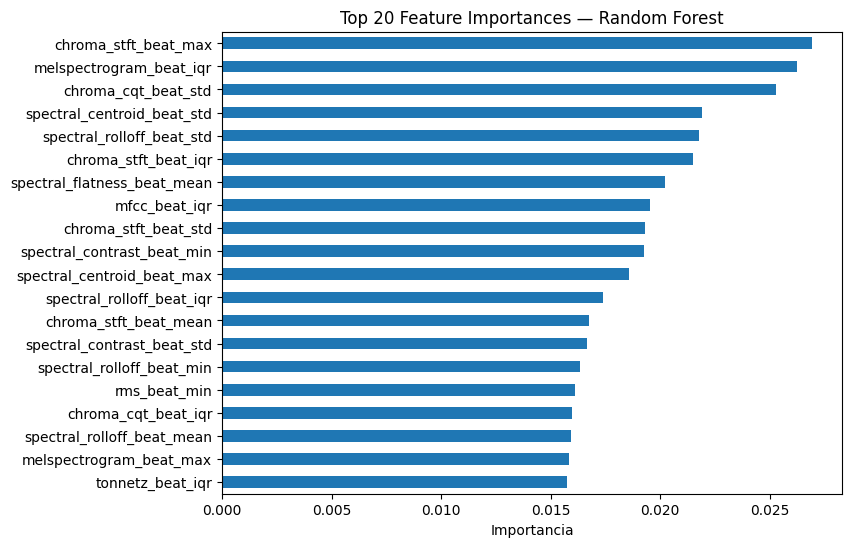

In [68]:
feature_names = X_train.columns.tolist()

# 2. Extrae importancias
importances = rf.feature_importances_  # array shape (n_features,)

# 3. Crea un Series y ordénalo
feat_imp = pd.Series(importances, index=feature_names)
feat_imp_sorted = feat_imp.sort_values(ascending=False)

# 4. Muestra las top 20
top_n = 20
print(f"Top {top_n} características más importantes:")
print(feat_imp_sorted.head(top_n))

# 5. (Opcional) un gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
feat_imp_sorted.head(top_n).plot.barh()
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances — Random Forest")
plt.xlabel("Importancia")
plt.show()

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Aplanar X_audio_norm para usarlo en Logistic Regression
X_audio_flat = X_audio_norm.reshape(X_audio_norm.shape[0], -1)

# Convertir las etiquetas a enteros (0-3)
y_labels = y.astype(int)

# Separar en train/val/test igual que antes
X_train, X_test, y_train, y_test = train_test_split(
    X_audio_flat, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)

# Entrenar modelo de regresión logística
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Evaluar en test
y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (Logistic Regression): {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy (Logistic Regression): 0.2586

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.17      0.20       200
           1       0.24      0.49      0.32       200
           2       0.28      0.23      0.25       200
           3       0.34      0.12      0.18       189

    accuracy                           0.26       789
   macro avg       0.28      0.26      0.24       789
weighted avg       0.28      0.26      0.24       789



## Prueba con LSTM

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y = df_merged_sampled['cuadrante'].to_numpy() - 1          # 0–3
y_cat = to_categorical(y, num_classes=4)                  # (N,4)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_audio_norm, y_cat,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, Bidirectional, LSTM, Dropout, Dense

model = Sequential([
    Masking(mask_value=0., input_shape=(MAX_BEATS, X_audio_norm.shape[2])),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/50
99/99 [==============================] - 42s 190ms/step - loss: 1.4064 - accuracy: 0.2349 - val_loss: 1.3854 - val_accuracy: 0.2548 - lr: 0.0010
Epoch 2/50
99/99 [==============================] - 24s 242ms/step - loss: 1.3881 - accuracy: 0.2583 - val_loss: 1.3843 - val_accuracy: 0.2636 - lr: 0.0010
Epoch 3/50
99/99 [==============================] - 82s 827ms/step - loss: 1.3830 - accuracy: 0.2799 - val_loss: 1.3833 - val_accuracy: 0.2548 - lr: 0.0010
Epoch 4/50
99/99 [==============================] - 77s 785ms/step - loss: 1.3843 - accuracy: 0.2545 - val_loss: 1.3824 - val_accuracy: 0.2636 - lr: 0.0010
Epoch 5/50
99/99 [==============================] - 75s 760ms/step - loss: 1.3796 - accuracy: 0.2710 - val_loss: 1.3831 - val_accuracy: 0.2636 - lr: 0.0010
Epoch 6/50
99/99 [==============================] - 76s 773ms/step - loss: 1.3773 - accuracy: 0.2675 - val_loss: 1.3847 - val_accuracy: 0.2586 - lr: 0.0010
Epoch 7/50
99/99 [==============================] - 78s 785ms/st

## Aplicar PCA al audio

In [37]:
num_songs = padded_beat_features.shape[0]
num_features = padded_beat_features.shape[2]
flattened_audio_features = padded_beat_features.reshape(num_songs, -1)

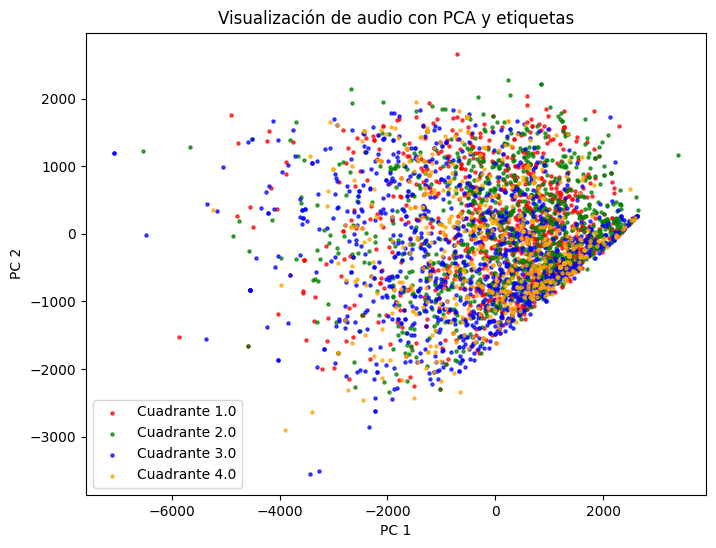

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
audio_array = pca.fit_transform(flattened_audio_features)

labels = df_merged_sampled["cuadReal"] 

plt.figure(figsize=(8, 6))

unique_labels = labels.unique()
colors = ["red", "green", "blue", "orange"]
label_to_color = dict(zip(unique_labels, colors))

for lbl in unique_labels:
    idx = labels == lbl
    plt.scatter(audio_array[idx, 0], audio_array[idx, 1],
                s=5, alpha=0.7,
                color=label_to_color[lbl],
                label=f"Cuadrante {lbl}")

plt.title("Visualización de audio con PCA y etiquetas")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()

In [ ]:
scaler_audio = StandardScaler()
scaled_audio_features = scaler_audio.fit_transform(flattened_audio_features)

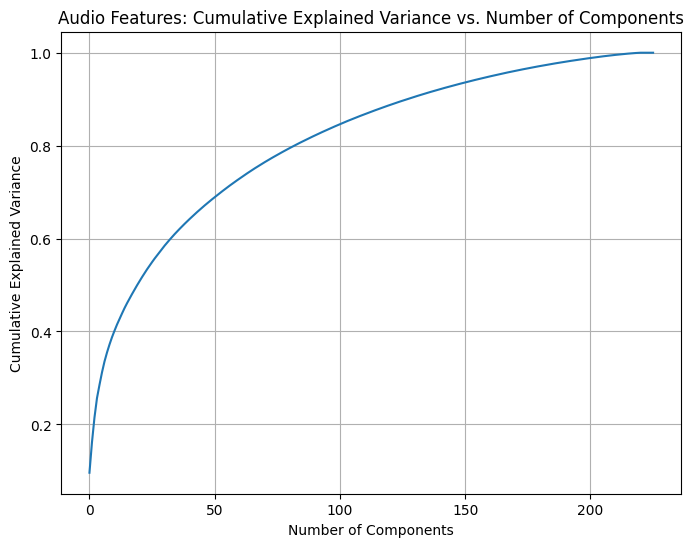

In [ ]:
pca_audio_full = PCA()
pca_audio_full.fit(scaled_audio_features)

explained_variance_ratio_audio = np.cumsum(pca_audio_full.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(explained_variance_ratio_audio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Audio Features: Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
pca_audio = PCA(n_components=175)
pca_audio_features = pca_audio.fit_transform(scaled_audio_features)
print(f"Number of audio components after PCA: {pca_audio.n_components_}")

Number of audio components after PCA: 175


In [ ]:
audio_features_array = pca_audio_features.reshape(num_songs, -1, pca_audio.n_components_) 

## Preparar características de texto

In [34]:
import tensorflow as tf
import transformers
import datasets

print("TensorFlow version:", tf.__version__)
print("Transformers version:", transformers.__version__)
print("Datasets version:", datasets.__version__)


c:\Users\andre\anaconda3\envs\tf_gpu_4\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow version: 2.10.1
Transformers version: 4.51.2
Datasets version: 3.5.0


In [35]:
df_merged_sampled['Idioma'].unique()

array(['en', 'fr', 'es', None, 'nl', 'it', 'de', 'pt', 'da', 'pl', 'ru',
       'la', 'ms', 'no', 'tr', 'eu', 'sv', 'romanization', 'ca', 'fi',
       'ko'], dtype=object)

In [36]:
import re
import pandas as pd

def clean_lyrics(lyrics_text):
    """
    Elimina las líneas que contienen texto entre corchetes, por ejemplo, [Chorus], [Intro], etc.
    """
    lyrics_str = str(lyrics_text)
    lines = lyrics_str.splitlines()
    cleaned_lines = []
    for line in lines:
        if re.search(r'\[.*?\]', line):
            continue
        cleaned_lines.append(line)

    return "\n".join(cleaned_lines)


df_merged_sampled['Lyrics_cleaned'] = df_merged_sampled['Lyrics'].apply(clean_lyrics)


In [37]:
df_merged_sampled['Lyrics']

0       Accidentally in Love Lyrics[Verse 1]\nSo, she ...
1       Heart Out Lyrics[Verse 1]\nRushing in a small ...
2       7 ContributorsKremlin Dusk LyricsAll along I w...
3       54 ContributorsDown & Out Lyrics[Intro]\nChka-...
4       2 ContributorsRock and Roll Music LyricsJust l...
                              ...                        
3939    45 ContributorsBoth Sides Now Lyrics[Intro]\n\...
3940    The Feeling’s Back LyricsI wrote a letter just...
3941    31 ContributorsVentura Highway Lyrics[Verse 1]...
3942    Keep Us Together Lyrics[Intro]\nBam-bam, ooh, ...
3943    Borderline Lyrics[Verse 1]\nEverybody looks so...
Name: Lyrics, Length: 3944, dtype: object

In [38]:
df_merged_sampled['Lyrics_cleaned'].iloc[0]

'So, she said, "What\'s the problem, baby?"\nWhat\'s the problem? I don\'t know\nWell, maybe I\'m in love (Love)\nThink about it\nEvery time I think about it\nCan\'t stop thinking \'bout it\nHow much longer will it take to cure this?\nJust to cure it, \'cause I can\'t ignore it if it\'s love (Love)\nMakes me wanna turn around and face me\nBut I don\'t know nothin\' \'bout love, uh\n\nCome on, come on\nTurn a little faster\nCome on, come on\nThe world will follow after\nCome on, come on\nBecause everybody\'s after love\n\nSo I said, I\'m a snowball runnin\'\nRunnin\' down into the spring that\'s comin\'\nAll this love meltin\' under blue skies\nBelting out sunlight, shimmering love\nWell, baby, I surrender\nTo this strawberry ice cream\nNever-ever-ender\nAll this love\nWell, I didn\'t mean to do it\nBut there\'s no escaping your love, oh\nThese lines of lightnin\' mean we\'re never alone\nNever alone\nNo, no\n\nCome on, come on\nMove a little closer\nCome on, come on\nI wanna hear you w

In [39]:
df_merged_sampled['Lyrics_proces'].iloc[0]

'said problem baby problem know maybe love love think time think stop thinking bout longer cure cure cause ignore love love makes wanna turn face know nothin bout love come come turn little faster come come world follow come come everybodys love said snowball runnin runnin spring comin love meltin blue skies belting sunlight shimmering love baby surrender strawberry ice cream nevereverender love mean escaping love like lines lightnin mean come come little closer come come wanna hear whisper come come settle inside love ohh come come jump little higher come come feel little lighter come come time love accidentally love accidentally love accidentally love accidentally love accidentally love accidentally love accidentally love accidentally love accidentally love love love love love love accidentally love love love love love love accidentally come come come spin little tighter come come come worlds little brighter come come come inside love love'

### Embbedings de texto

In [37]:
import os
import joblib
import transformers
from sentence_transformers import SentenceTransformer

embedding_filename = "hf_embeddings_NewCuadranteFinal.joblib"
model_name = "sentence-transformers/LaBSE"

if os.path.exists(embedding_filename):
    # Cargamos los embeddings pre-generados
    print(f"Loading precomputed embeddings from {embedding_filename}...")
    hf_embeddings = joblib.load(embedding_filename)
    print("Embeddings loaded.")
else:
    # Cargamos el modelo preentrenado de Sentence-BERT
    print(f"Loading the SentenceTransformer model: {model_name}...")
    model = SentenceTransformer(model_name)

    print("Generating embeddings for lyrics...")
    hf_embeddings = model.encode(
        df_merged_sampled["Lyrics_proces"].tolist(),
        batch_size=32,           # Ajusta según tu hardware
        show_progress_bar=True   
    )

    print("Embeddings generated. Saving to disk...")
    joblib.dump(hf_embeddings, embedding_filename)
    print(f"Embeddings saved as {embedding_filename}.")

print("Shape of hf_embeddings:", hf_embeddings.shape)


c:\Users\andre\anaconda3\envs\tf_gpu_4\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Transformers is only compatible with Keras 2, but you have explicitly set `TF_USE_LEGACY_KERAS` to `0`. This may result in unexpected behaviour or errors if Keras 3 objects are passed to Transformers models.


Loading the SentenceTransformer model: sentence-transformers/LaBSE...
Generating embeddings for lyrics...


Batches: 100%|██████████| 74/74 [10:44<00:00,  8.71s/it]

Embeddings generated. Saving to disk...
Embeddings saved as hf_embeddings_NewCuadranteFinal.joblib.
Shape of hf_embeddings: (2347, 768)


In [42]:
del df, df_audio_1,df_audio_2,df_audio_3,df_audio_4,df_audio_5,df_audio_6,df_audio_7,df_audio_features

### modelo sentiment 

In [40]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

PRETRAINED = "bert-base-multilingual-cased"

# 1.1 Tokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)

# 1.2 Carga la parte “encoder” de BERT sin la cabeza de clasificación
bert_encoder = TFAutoModel.from_pretrained(PRETRAINED)

# 1.3 Define la arquitectura Keras
# — Entradas —
input_ids      = tf.keras.Input(shape=(256,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(256,), dtype=tf.int32, name="attention_mask")

# — BERT produce outputs.last_hidden_state —
outputs = bert_encoder(input_ids, attention_mask=attention_mask)
cls_token = outputs.last_hidden_state[:, 0, :]    # token [CLS]

# — Cabeza de clasificación —
x = tf.keras.layers.Dropout(0.3)(cls_token)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
logits = tf.keras.layers.Dense(4, activation="softmax")(x)

model_text = tf.keras.Model(
    inputs=[input_ids, attention_mask],
    outputs=logits,
    name="bert_multilang_cls"
)


c:\Users\andre\anaconda3\envs\tf_gpu_4\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Transformers is only compatible with Keras 2, but you have explicitly set `TF_USE_LEGACY_KERAS` to `0`. This may result in unexpected behaviour or errors if Keras 3 objects are passed to Transformers models.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassifica

In [41]:
from tensorflow.keras.optimizers import Adam

model_text.compile(
    optimizer=Adam(learning_rate=2e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [42]:
enc = tokenizer(
    df_merged_sampled["Lyrics_cleaned"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=256,
    return_tensors="tf"
)
input_ids_arr      = enc["input_ids"]
attention_mask_arr = enc["attention_mask"]

# Etiquetas
y = df_merged_sampled["cuadrante"].astype(int) - 1  # 0–3
y = tf.convert_to_tensor(y.values, dtype=tf.int32)

# Split 80/20
N = len(y)
idx = tf.random.shuffle(tf.range(N), seed=42)
split = int(0.8 * N)
train_idx, val_idx = idx[:split], idx[split:]

x_train = {
    "input_ids":      tf.gather(input_ids_arr, train_idx),
    "attention_mask": tf.gather(attention_mask_arr, train_idx)
}
y_train = tf.gather(y, train_idx)

x_val = {
    "input_ids":      tf.gather(input_ids_arr, val_idx),
    "attention_mask": tf.gather(attention_mask_arr, val_idx)
}
y_val = tf.gather(y, val_idx)

In [45]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6)
]

history = model_text.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=8,
    callbacks=callbacks
)


Epoch 1/50
395/395 [==============================] - 130s 327ms/step - loss: 1.4088 - accuracy: 0.2571 - val_loss: 1.3895 - val_accuracy: 0.2497 - lr: 2.0000e-04
Epoch 2/50
395/395 [==============================] - 124s 315ms/step - loss: 1.3904 - accuracy: 0.2501 - val_loss: 1.3862 - val_accuracy: 0.2662 - lr: 2.0000e-04
Epoch 3/50
395/395 [==============================] - 122s 308ms/step - loss: 1.3878 - accuracy: 0.2450 - val_loss: 1.3862 - val_accuracy: 0.2446 - lr: 2.0000e-04
Epoch 4/50
395/395 [==============================] - 125s 317ms/step - loss: 1.3875 - accuracy: 0.2552 - val_loss: 1.3862 - val_accuracy: 0.2446 - lr: 2.0000e-04
Epoch 5/50
395/395 [==============================] - 126s 319ms/step - loss: 1.3874 - accuracy: 0.2532 - val_loss: 1.3862 - val_accuracy: 0.2446 - lr: 2.0000e-04
Epoch 6/50
395/395 [==============================] - 123s 311ms/step - loss: 1.3881 - accuracy: 0.2561 - val_loss: 1.3862 - val_accuracy: 0.2446 - lr: 2.0000e-04
Epoch 7/50
395/395 [==

## PCA para embbedings

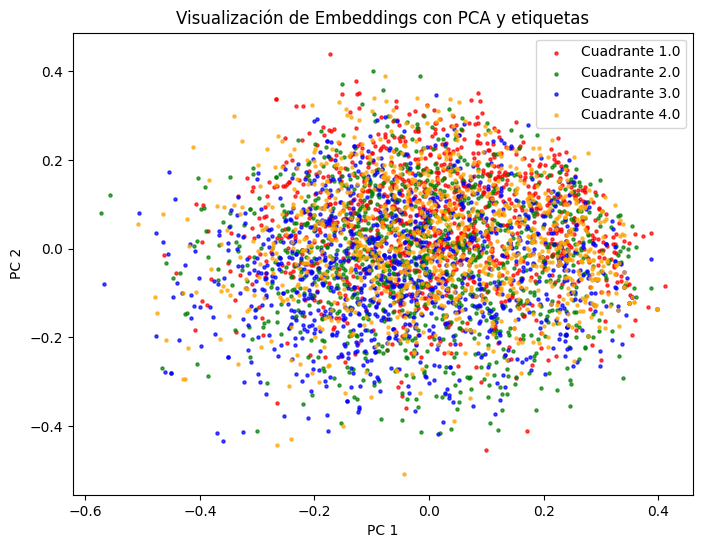

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(hf_embeddings)

labels = df_merged_sampled["cuadReal"] 

plt.figure(figsize=(8, 6))

unique_labels = labels.unique()
colors = ["red", "green", "blue", "orange"]
label_to_color = dict(zip(unique_labels, colors))

for lbl in unique_labels:
    idx = labels == lbl
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1],
                s=5, alpha=0.7,
                color=label_to_color[lbl],
                label=f"Cuadrante {lbl}")

plt.title("Visualización de Embeddings con PCA y etiquetas")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()


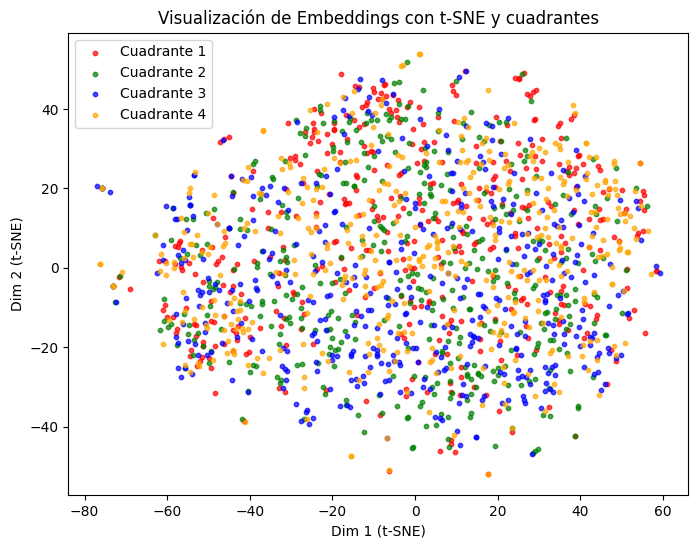

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Suponiendo que tus embeddings son hf_embeddings con forma (N, D)
# Y tus cuadrantes están en df_merged_sampled["cuadReal"]

# Extrae los cuadrantes como un array
labels = df_merged_sampled["cuadReal"].values

# Aplica t-SNE para reducir a 2 dimensiones
tsne = TSNE( perplexity=10, random_state=42)
embeddings_2d_tsne = tsne.fit_transform(hf_embeddings)

# Grafica los puntos, coloreados por cuadrante
plt.figure(figsize=(8, 6))

unique_labels = np.unique(labels)
colors = ["red", "green", "blue", "orange", "purple", "cyan"]  # Ajusta si hay más cuadrantes

# Asigna un color a cada cuadrante
label_to_color = {lbl: colors[i % len(colors)] for i, lbl in enumerate(unique_labels)}

for lbl in unique_labels:
    idx = labels == lbl
    plt.scatter(embeddings_2d_tsne[idx, 0], embeddings_2d_tsne[idx, 1],
                s=10, alpha=0.7,
                color=label_to_color[lbl],
                label=f"Cuadrante {lbl}")

plt.title("Visualización de Embeddings con t-SNE y cuadrantes")
plt.xlabel("Dim 1 (t-SNE)")
plt.ylabel("Dim 2 (t-SNE)")
plt.legend()
plt.show()


In [ ]:
scaler_text = StandardScaler(with_mean=False) #with_mean = False, since the data is sparse
tfidf_matrix_scaled = scaler_text.fit_transform(tfidf_matrix)

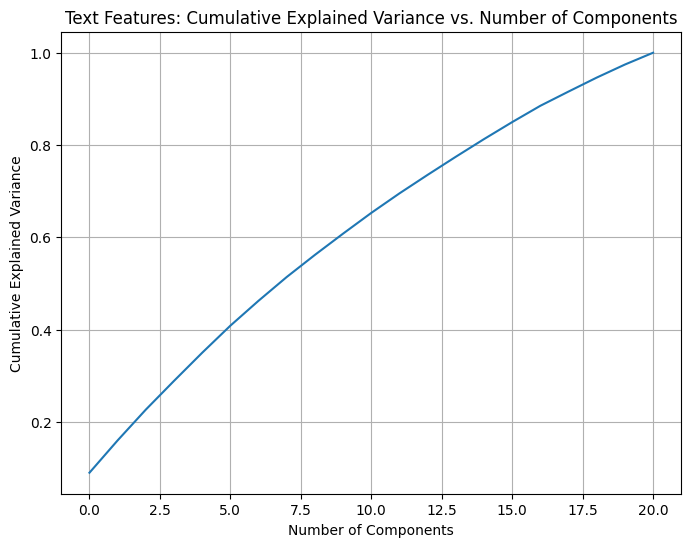

In [ ]:
pca_text_full = PCA()
pca_text_full.fit(tfidf_matrix_scaled.toarray())  

explained_variance_ratio_text = np.cumsum(pca_text_full.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(explained_variance_ratio_text)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Text Features: Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
pca_text = PCA(n_components=800)
pca_text_features = pca_text.fit_transform(tfidf_matrix_scaled.toarray())
print(f"Number of text components after PCA: {pca_text.n_components_}")

Number of text components after PCA: 800


In [ ]:
df.head(2)

,song_id,Idioma,lyrics_state,hasLetra,Lyrics,Lyrics_proces,track_uri,emocion_mas_comun,cuadrante,cuadReal
0,21 seconds - dj swiss dan da man remix vocal -...,en,complete,1.0,7 ContributorsAngela’s Ashes LyricsAngela's As...,angelas ashes memoir childhood frank mccourt b...,spotify:track:0N9LQXtUL7TLtIoa7gpJfX,3,0,1
1,240 - samad savage,en,complete,1.0,18 ContributorsI Knew I Loved You Lyrics[Intro...,cool cruel sleaze hungry wild crawling storm b...,spotify:track:0GYXt2CnvXNXA1Bv6n493A,3,0,1


In [ ]:
df_audio_features.head(2)

,song_id,beat_features
0,240 - samad savage,"[[0.1179114505648613, 0.11783639341592789, 0.2..."
1,21 seconds - dj swiss dan da man remix vocal -...,"[[0.6232354044914246, 0.7310153841972351, 0.68..."


In [ ]:
df_merged.head(2)

,Idioma,lyrics_state,hasLetra,Lyrics,Lyrics_proces,song_id,track_uri,emocion_mas_comun,cuadrante,cuadReal,beat_features
0,en,complete,1.0,7 ContributorsAngela’s Ashes LyricsAngela's As...,angelas ashes memoir childhood frank mccourt b...,21 seconds - dj swiss dan da man remix vocal -...,spotify:track:0N9LQXtUL7TLtIoa7gpJfX,3,0,1,"[[0.6232354044914246, 0.7310153841972351, 0.68..."
1,en,complete,1.0,18 ContributorsI Knew I Loved You Lyrics[Intro...,cool cruel sleaze hungry wild crawling storm b...,240 - samad savage,spotify:track:0GYXt2CnvXNXA1Bv6n493A,3,0,1,"[[0.1179114505648613, 0.11783639341592789, 0.2..."


In [ ]:
scaled_audio_features.shape

(226, 14934)

## Metadatos

In [107]:
# Ejemplo X_meta con sólo las 6 columnas que quieres:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# One‑hot emoción más común
X_emc = pd.get_dummies(df_merged_sampled['emocion_mas_comun'].astype(int), prefix='emc').values

# Numéricas
num_cols = ['acousticness','loudness','danceability','valence','energy']
X_num = df_merged_sampled[num_cols].values
X_num = StandardScaler().fit_transform(X_num)

# Concatena
X_meta = np.concatenate([X_num], axis=1)  # shape (N, emc_classes + 5)


## Train y test

In [ ]:
X_text = hf_embeddings

y = df_merged_sampled['cuadrante'].values.astype(int)
y = tf.keras.utils.to_categorical(y, num_classes=5) 
y = y[:, 1:] 

In [113]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(X_audio))
# 1) Primero separa el 15% para TEST
Xa_rest, Xa_test, Xt_rest, Xt_test, Xm_rest, Xm_test, y_rest, y_test, idx_train, idx_test = train_test_split(
    X_audio, X_text, X_meta,y,indices,
    test_size=0.15,
    stratify=y,
    random_state=42
)

val_size = 0.15 / 0.85  # ≈ 0.17647

Xa_train, Xa_val, Xt_train, Xt_val, Xm_train, Xm_val, y_train, y_val = train_test_split(
    Xa_rest, Xt_rest, Xm_rest, y_rest,
    test_size=val_size,
    stratify=y_rest,
    random_state=42
)

# Comprueba proporciones
print("Train:", Xa_train.shape[0], 
      "Val:",   Xa_val.shape[0], 
      "Test:",  Xa_test.shape[0])


Train: 1642 Val: 352 Test: 353


## Modelo Base con Audio

In [52]:
Xa_train.shape, Xt_train.shape, y_train.shape   

((1642, 454, 38), (1642, 768), (1642, 4))

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Asegúrate de que las dimensiones de X_audio sean adecuadas para Random Forest
X_audio_flattened = Xa_train.reshape(Xa_train.shape[0], -1)  # Aplanar las características de audio para entrenamiento
X_audio_val_flattened = Xa_val.reshape(Xa_val.shape[0], -1)
X_audio_test_flattened = Xa_test.reshape(Xa_test.shape[0], -1)

# Convertir la variable objetivo a etiquetas enteras
y_train_labels = np.argmax(y_train, axis=1) + 1
y_val_labels = np.argmax(y_val, axis=1) + 1
y_test_labels = np.argmax(y_test, axis=1) + 1

# Crear el modelo de Random Forest
rf_audio_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_audio_model.fit(X_audio_flattened, y_train_labels)

# Evaluar en el conjunto de validación
y_val_pred = rf_audio_model.predict(X_audio_val_flattened)
val_accuracy = accuracy_score(y_val_labels, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluar en el conjunto de prueba
y_test_pred = rf_audio_model.predict(X_audio_test_flattened)
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Mostrar el reporte de clasificación
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test_labels, y_test_pred))

Validation Accuracy: 0.3182
Test Accuracy: 0.3173

Classification Report (Test Set):

              precision    recall  f1-score   support

           1       0.33      0.38      0.35        90
           2       0.30      0.31      0.31        90
           3       0.27      0.21      0.24        90
           4       0.35      0.37      0.36        83

    accuracy                           0.32       353
   macro avg       0.31      0.32      0.32       353
weighted avg       0.31      0.32      0.31       353



## Modelo base con embbedings

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Asegúrate de que las dimensiones de X_text sean adecuadas para Random Forest
X_text_flattened = Xt_train  # X_text ya está en forma plana
X_text_val_flattened = Xt_val
X_text_test_flattened = Xt_test

# Convertir la variable objetivo a etiquetas enteras
y_train_labels = np.argmax(y_train, axis=1) + 1
y_val_labels = np.argmax(y_val, axis=1) + 1
y_test_labels = np.argmax(y_test, axis=1) + 1

# Crear el modelo de Random Forest
rf_text_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_text_model.fit(X_text_flattened, y_train_labels)

# Evaluar en el conjunto de validación
y_val_pred = rf_text_model.predict(X_text_val_flattened)
val_accuracy = accuracy_score(y_val_labels, y_val_pred)
print(f"Validation Accuracy (Text): {val_accuracy:.4f}")

# Evaluar en el conjunto de prueba
y_test_pred = rf_text_model.predict(X_text_test_flattened)
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy (Text): {test_accuracy:.4f}")

# Mostrar el reporte de clasificación
print("\nClassification Report (Test Set - Text):\n")
print(classification_report(y_test_labels, y_test_pred))

Validation Accuracy (Text): 0.3040
Test Accuracy (Text): 0.3258

Classification Report (Test Set - Text):

              precision    recall  f1-score   support

           1       0.30      0.41      0.35        90
           2       0.36      0.32      0.34        90
           3       0.22      0.16      0.18        90
           4       0.41      0.42      0.41        83

    accuracy                           0.33       353
   macro avg       0.32      0.33      0.32       353
weighted avg       0.32      0.33      0.32       353



## Modelo multimodal con random forest

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Concatenar las características de audio y texto
X_audio_flattened = Xa_train.reshape(Xa_train.shape[0], -1)  # Aplanar las características de audio
X_audio_val_flattened = Xa_val.reshape(Xa_val.shape[0], -1)
X_audio_test_flattened = Xa_test.reshape(Xa_test.shape[0], -1)

X_train_combined = np.concatenate([X_audio_flattened, Xt_train], axis=1)
X_val_combined = np.concatenate([X_audio_val_flattened, Xt_val], axis=1)
X_test_combined = np.concatenate([X_audio_test_flattened, Xt_test], axis=1)

# Convertir la variable objetivo a etiquetas enteras
y_train_labels = np.argmax(y_train, axis=1) + 1
y_val_labels = np.argmax(y_val, axis=1) + 1
y_test_labels = np.argmax(y_test, axis=1) + 1

# Crear el modelo de Random Forest
rf_combined_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_combined_model.fit(X_train_combined, y_train_labels)

# Evaluar en el conjunto de validación
y_val_pred = rf_combined_model.predict(X_val_combined)
val_accuracy = accuracy_score(y_val_labels, y_val_pred)
print(f"Validation Accuracy (Combined): {val_accuracy:.4f}")

# Evaluar en el conjunto de prueba
y_test_pred = rf_combined_model.predict(X_test_combined)
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy (Combined): {test_accuracy:.4f}")

# Mostrar el reporte de clasificación
print("\nClassification Report (Test Set - Combined):\n")
print(classification_report(y_test_labels, y_test_pred))

Validation Accuracy (Combined): 0.3267
Test Accuracy (Combined): 0.3059

Classification Report (Test Set - Combined):

              precision    recall  f1-score   support

           1       0.29      0.37      0.32        90
           2       0.30      0.32      0.31        90
           3       0.32      0.24      0.28        90
           4       0.32      0.29      0.31        83

    accuracy                           0.31       353
   macro avg       0.31      0.31      0.30       353
weighted avg       0.31      0.31      0.30       353



In [ ]:
# Obtener las importancias de las características del modelo combinado
feature_importances_combined = rf_combined_model.feature_importances_

# Crear nombres para las características
num_audio_features = X_audio_flattened.shape[1]
num_text_features = Xt_train.shape[1]

audio_feature_names = [f'Audio_Feature_{i+1}' for i in range(num_audio_features)]
text_feature_names = [f'Text_Feature_{i+1}' for i in range(num_text_features)]

combined_feature_names = audio_feature_names + text_feature_names

# Crear un DataFrame para visualizar las importancias
importance_df_combined = pd.DataFrame({
    'Feature': combined_feature_names,
    'Importance': feature_importances_combined
}).sort_values(by='Importance', ascending=False)


In [63]:
# Filtrar características de audio
audio_importances = importance_df_combined[importance_df_combined['Feature'].str.contains('Audio_Feature')]

# Filtrar características de texto
text_importances = importance_df_combined[importance_df_combined['Feature'].str.contains('Text_Feature')]

# Ordenar por importancia descendente
audio_importances_sorted = audio_importances.sort_values(by='Importance', ascending=False).head(10)
text_importances_sorted = text_importances.sort_values(by='Importance', ascending=False).head(10)

print("Características de audio más relevantes:")
print(audio_importances_sorted)

print("\nCaracterísticas de texto más relevantes:")
print(text_importances_sorted)

Características de audio más relevantes:
                 Feature  Importance
870    Audio_Feature_871    0.000426
345    Audio_Feature_346    0.000418
832    Audio_Feature_833    0.000406
2833  Audio_Feature_2834    0.000404
1708  Audio_Feature_1709    0.000384
1641  Audio_Feature_1642    0.000381
4274  Audio_Feature_4275    0.000380
343    Audio_Feature_344    0.000369
5188  Audio_Feature_5189    0.000364
4547  Audio_Feature_4548    0.000363

Características de texto más relevantes:
                Feature  Importance
17528  Text_Feature_277    0.000727
17491  Text_Feature_240    0.000697
17650  Text_Feature_399    0.000647
17270   Text_Feature_19    0.000633
17948  Text_Feature_697    0.000617
17435  Text_Feature_184    0.000613
17856  Text_Feature_605    0.000605
17568  Text_Feature_317    0.000597
17740  Text_Feature_489    0.000594
17297   Text_Feature_46    0.000566


## Modelo audio + texto con logistic regression


In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Asegúrate de que las dimensiones de X_audio y X_text sean adecuadas
X_audio_flattened = Xa_train.reshape(Xa_train.shape[0], -1)  # Aplanar las características de audio
X_audio_val_flattened = Xa_val.reshape(Xa_val.shape[0], -1)
X_audio_test_flattened = Xa_test.reshape(Xa_test.shape[0], -1)

# Concatenar las características de audio y texto
X_train_combined = np.concatenate([X_audio_flattened, Xt_train], axis=1)
X_val_combined = np.concatenate([X_audio_val_flattened, Xt_val], axis=1)
X_test_combined = np.concatenate([X_audio_test_flattened, Xt_test], axis=1)

# Convertir la variable objetivo a etiquetas enteras
y_train_labels = np.argmax(y_train, axis=1) + 1
y_val_labels = np.argmax(y_val, axis=1) + 1
y_test_labels = np.argmax(y_test, axis=1) + 1

# Crear el modelo de regresión logística
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Entrenar el modelo
logistic_model.fit(X_train_combined, y_train_labels)

# Evaluar en el conjunto de validación
y_val_pred = logistic_model.predict(X_val_combined)
val_accuracy = accuracy_score(y_val_labels, y_val_pred)
print(f"Validation Accuracy (Logistic Regression): {val_accuracy:.4f}")

# Evaluar en el conjunto de prueba
y_test_pred = logistic_model.predict(X_test_combined)
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy (Logistic Regression): {test_accuracy:.4f}")

# Mostrar el reporte de clasificación
print("\nClassification Report (Test Set - Logistic Regression):\n")
print(classification_report(y_test_labels, y_test_pred))

c:\Users\andre\anaconda3\envs\tf_gpu_4\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy (Logistic Regression): 0.2812
Test Accuracy (Logistic Regression): 0.2663

Classification Report (Test Set - Logistic Regression):

              precision    recall  f1-score   support

           1       0.25      0.24      0.25        90
           2       0.25      0.27      0.26        90
           3       0.26      0.26      0.26        90
           4       0.31      0.30      0.30        83

    accuracy                           0.27       353
   macro avg       0.27      0.27      0.27       353
weighted avg       0.27      0.27      0.27       353



## Modelo multimodal : Audio + texto 

In [120]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, Bidirectional,
    Dense, Dropout, Concatenate,
    MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_rnn_multimodal_model_with_cross_attention(
    max_len_frames: int,
    num_audio_features: int,
    text_dim: int,
    num_classes: int = 4,
    lr: float = 1e-4,
    num_heads: int = 4,
    key_dim: int = 32
) -> tf.keras.Model:
    # — Inputs —
    aud_in = Input((max_len_frames, num_audio_features), name='audio_input')
    txt_in = Input((text_dim,), name='text_input')

    # — Audio branch: 2×BiLSTM → proyectar a 128 → Dropout —
    # Primer BiLSTM con return_sequences
    a = Bidirectional(LSTM(64, return_sequences=True), name='aud_bilstm1')(aud_in)
    # Segundo BiLSTM para obtener una secuencia final de 128 dim
    a = Bidirectional(LSTM(64, return_sequences=False), name='aud_bilstm2')(a)  
    # a tiene ahora shape (batch, 128)
    a = Dropout(0.3, name='aud_dropout')(a)

    # — Text branch: Dense a 128 → Dropout —
    t = Dense(128, activation='relu', name='txt_dense1')(txt_in)  # (batch,128)
    t = Dropout(0.3, name='txt_dropout1')(t)

    # — Convertir en secuencias de longitud 1 para atención — 
    a_seq = tf.expand_dims(a, axis=1)  # (batch,1,128)
    t_seq = tf.expand_dims(t, axis=1)  # (batch,1,128)

    # — Cross‐modal Attention — 
    attn = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        name='cross_attn'
    )
    # audio queries texto
    a2t = attn(query=a_seq, value=t_seq, key=t_seq)  # (batch,1,128)
    # texto queries audio
    t2a = attn(query=t_seq, value=a_seq, key=a_seq)  # (batch,1,128)

    # — Aplanar y normalizar — 
    a2t = LayerNormalization()(tf.squeeze(a2t, axis=1))  # (batch,128)
    t2a = LayerNormalization()(tf.squeeze(t2a, axis=1))  # (batch,128)

    # — Fusión final — 
    merged = Concatenate(name='fusion')([a, t, a2t, t2a])  # (batch, 128×4 = 512)

    # — Clasificación — 
    x = Dense(256, activation='relu', name='clf_dense1')(merged)
    x = Dropout(0.3, name='clf_dropout1')(x)
    x = Dense(128, activation='relu', name='clf_dense2')(x)
    x = Dropout(0.2, name='clf_dropout2')(x)
    out = Dense(num_classes, activation='softmax', name='cuad_output')(x)

    model = Model([aud_in, txt_in], out, name='RNN_Multimodal_CrossAttn')
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [121]:
model = create_rnn_multimodal_model_with_cross_attention(
    max_len_frames=454,
    num_audio_features=38,
    text_dim=768,
    num_classes=4,
    lr=1e-4,
    num_heads=1,
    key_dim=32
)
model.summary()

Model: "RNN_Multimodal_CrossAttn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 audio_input (InputLayer)       [(None, 454, 38)]    0           []                               
                                                                                                  
 aud_bilstm1 (Bidirectional)    (None, 454, 128)     52736       ['audio_input[0][0]']            
                                                                                                  
 text_input (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 aud_bilstm2 (Bidirectional)    (None, 128)          98816       ['aud_bilstm1[0][0]']            
                                                                           

In [122]:
from sklearn.model_selection import train_test_split

history = model.fit(
    x = {
      'audio_input': Xa_train,
      'text_input' : Xt_train,
      #'meta_input' : Xm_train
    },
    y = y_train,
    validation_data = (
      {
        'audio_input': Xa_val,
        'text_input' : Xt_val,
        #'meta_input' : Xm_val
      },
      y_val
    ),
    epochs=35,
    batch_size=16,
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7)
    ]
)


Epoch 1/35


c:\Users\andre\anaconda3\envs\tf_gpu_4\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['meta_input'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


103/103 [==============================] - 24s 126ms/step - loss: 1.4260 - accuracy: 0.2436 - val_loss: 1.3886 - val_accuracy: 0.2756 - lr: 1.0000e-04
Epoch 2/35
103/103 [==============================] - 11s 106ms/step - loss: 1.4045 - accuracy: 0.2418 - val_loss: 1.3872 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 3/35
103/103 [==============================] - 11s 104ms/step - loss: 1.3893 - accuracy: 0.2625 - val_loss: 1.3882 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 4/35
103/103 [==============================] - 17s 166ms/step - loss: 1.3794 - accuracy: 0.2625 - val_loss: 1.3692 - val_accuracy: 0.3011 - lr: 1.0000e-04
Epoch 5/35
103/103 [==============================] - 40s 389ms/step - loss: 1.3593 - accuracy: 0.3136 - val_loss: 1.3666 - val_accuracy: 0.2614 - lr: 1.0000e-04
Epoch 6/35
103/103 [==============================] - 37s 358ms/step - loss: 1.3511 - accuracy: 0.3197 - val_loss: 1.3493 - val_accuracy: 0.2983 - lr: 1.0000e-04
Epoch 7/35
103/103 [===================

In [123]:
loss, accuracy = model.evaluate({'audio_input': Xa_test, 'text_input': Xt_test}, y_test, verbose=0)
print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy:.4f}")

Final Test Loss: 1.3665
Final Test Accuracy: 0.3031


In [124]:
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

Final Validation Loss: 1.3784
Final Validation Accuracy: 0.3494


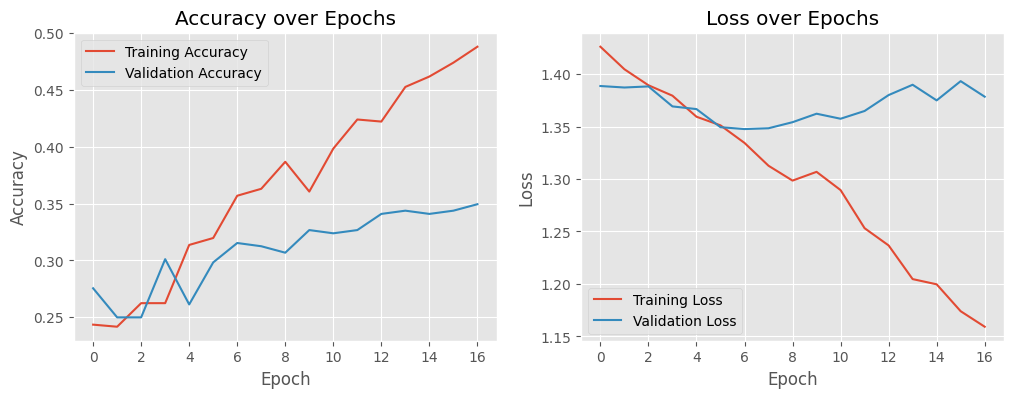

In [125]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


## Metricas de Validación

In [126]:
predictions = model.predict({'audio_input': Xa_test, 'text_input': Xt_test})
predicted_classes = np.argmax(predictions, axis=1) + 1  
y_test_labels = np.argmax(y_test, axis=1) + 1

12/12 [==============================] - 6s 182ms/step


Umbrales óptimos por clase: {0: 0.17, 1: 0.17, 2: 0.2, 3: 0.26}
=== Matriz tras thresholding ===


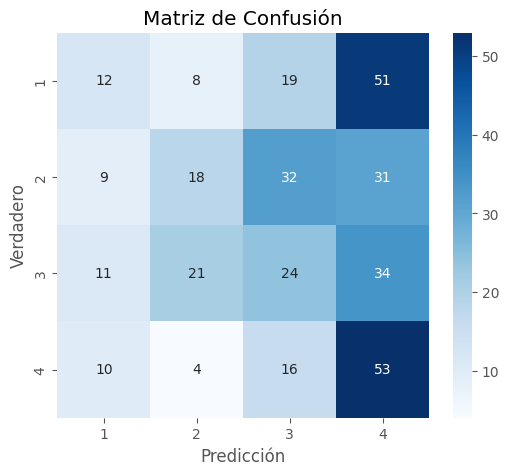

              precision    recall  f1-score   support

          C1       0.29      0.13      0.18        90
          C2       0.35      0.20      0.26        90
          C3       0.26      0.27      0.27        90
          C4       0.31      0.64      0.42        83

    accuracy                           0.30       353
   macro avg       0.30      0.31      0.28       353
weighted avg       0.30      0.30      0.28       353



In [127]:
import numpy as np
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize

y_val_bin = label_binarize(y_test_labels, classes=[1,2,3,4])

# 2.3 Busca el umbral que maximice F1 para cada clase
best_thresh = {}
for i in range(4):
    best_f1, best_t = 0, 0.5
    for t in np.linspace(0,1,101):
        y_pred_i = (predictions[:,i] >= t).astype(int)
        f1 = f1_score(y_val_bin[:,i], y_pred_i)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    best_thresh[i] = best_t
print("Umbrales óptimos por clase:", best_thresh)

# 2.4 Predecir en test aplicando esos umbrales
y_test_score = predictions  # shape (n_test,4)
n_test = y_test_score.shape[0]

y_thresh_bin = np.zeros_like(y_test_score, dtype=int)
for i in range(4):
    y_thresh_bin[:,i] = (y_test_score[:,i] >= best_thresh[i]).astype(int)

# 2.5 Convertir ese binarizado en etiqueta final:
# si un sample cruza varios umbrales, elige el que tenga mayor score; 
# si ninguno lo cruza, recae en el argmax original.

y_pred_thresh = []
for j in range(n_test):
    hits = np.where(y_thresh_bin[j]==1)[0]
    if len(hits)==1:
        y_pred_thresh.append(hits[0]+1)
    elif len(hits)>1:
        # de los que pasaron umbral, elige el que mayor probabilidad tenga
        best = hits[np.argmax(y_test_score[j,hits])]
        y_pred_thresh.append(best+1)
    else:
        # ninguno pasó el umbral → fallback a argmax
        y_pred_thresh.append(np.argmax(y_test_score[j])+1)

y_pred_thresh = np.array(y_pred_thresh)

cm2 = confusion_matrix(y_test_labels, y_pred_thresh, labels=[1,2,3,4])

print("=== Matriz tras thresholding ===")
plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(
    y_test_labels, y_pred_thresh,
    labels=[1,2,3,4],
    target_names=["C1","C2","C3","C4"]
))


In [128]:
# 3. Crear el DataFrame de visualización
plot_df = pd.DataFrame({
    'songId': df_merged_sampled.iloc[idx_test]['song_id'].values, 
    'predicted_quadrant': predicted_classes,
    'true_quadrant': y_test_labels,
    'cuadReal': df_merged_sampled.iloc[idx_test]['cuadReal'].values,
    'cuadrante': df_merged_sampled.iloc[idx_test]['cuadrante'].values,
    'emocion_mas_comun': df_merged_sampled.iloc[idx_test]['emocion_mas_comun'].values
})

plot_df = plot_df.dropna()
plot_df[['predicted_quadrant', 'true_quadrant']] = plot_df[['predicted_quadrant', 'true_quadrant']].astype(int)
plot_df['prediction_correct'] = plot_df['predicted_quadrant'] == plot_df['true_quadrant']

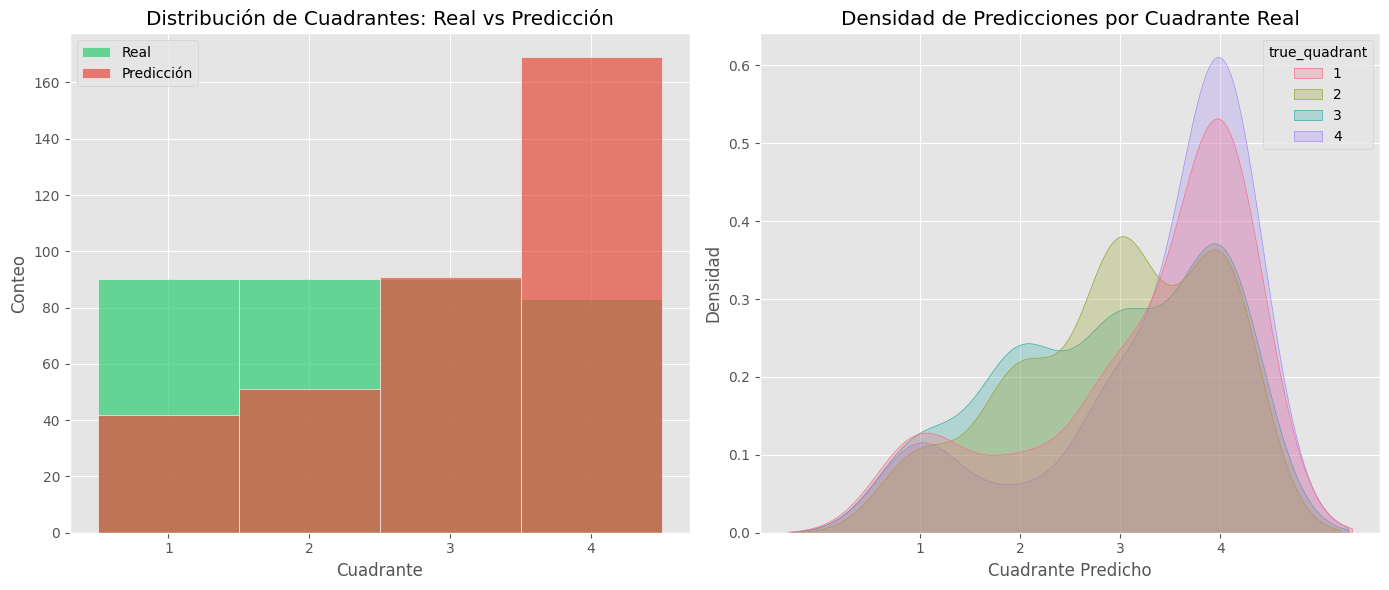

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
palette = sns.color_palette("husl", 4)

# 1. Histograma comparativo de distribución de cuadrantes
plt.figure(figsize=(14, 6))

# Gráfico para predicciones vs realidad
plt.subplot(1, 2, 1)
sns.histplot(data=plot_df, x='true_quadrant', bins=4, discrete=True,
             color='#2ecc71', alpha=0.7, label='Real', kde=False)
sns.histplot(data=plot_df, x='predicted_quadrant', bins=4, discrete=True,
             color='#e74c3c', alpha=0.7, label='Predicción', kde=False)
plt.title('Distribución de Cuadrantes: Real vs Predicción')
plt.xlabel('Cuadrante')
plt.ylabel('Conteo')
plt.xticks([1, 2, 3, 4])
plt.legend()

# 2. Matriz de densidad por cuadrante
plt.subplot(1, 2, 2)
sns.kdeplot(data=plot_df, x='predicted_quadrant', hue='true_quadrant',
            palette=palette, common_norm=False, fill=True, alpha=0.3)
plt.title('Densidad de Predicciones por Cuadrante Real')
plt.xlabel('Cuadrante Predicho')
plt.ylabel('Densidad')
plt.xticks([1, 2, 3, 4])

plt.tight_layout()
plt.show()



C:\Users\andre\AppData\Local\Temp\ipykernel_22760\4067112329.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=match_percentages.values, palette=colors)


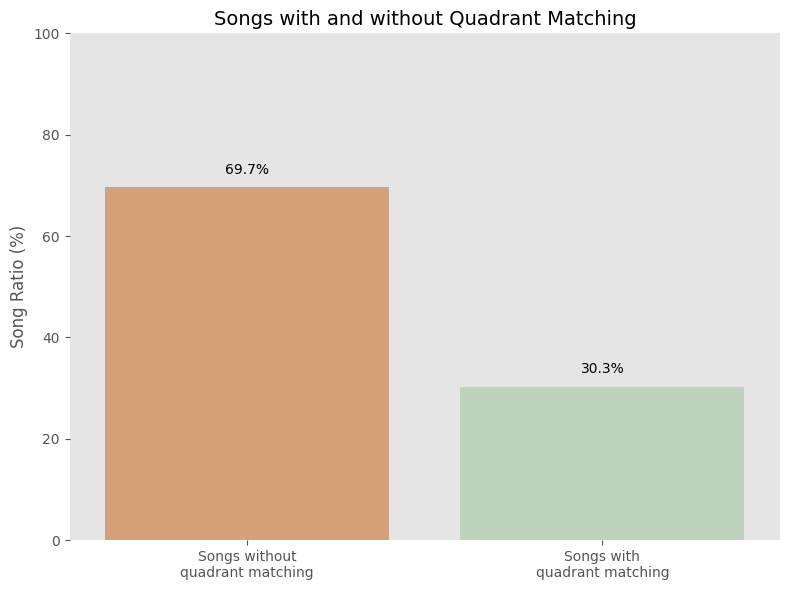

quadrant_match
False    69.7
True     30.3
Name: count, dtype: float64


In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Calcula match_percentages como antes
plot_df['quadrant_match'] = plot_df['predicted_quadrant'] == plot_df['cuadrante']
match_counts = plot_df['quadrant_match'].value_counts()
match_percentages = (match_counts / len(plot_df) * 100).round(1)

# 2) Reindexa en el orden deseado: primero False, luego True
match_percentages = match_percentages.reindex([False, True])

# 3) Define las etiquetas en ese mismo orden
labels = ['Songs without\nquadrant matching', 'Songs with\nquadrant matching']
colors = ['#E69F66', '#B9D7B9']

# 4) Dibuja el barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=labels, y=match_percentages.values, palette=colors)

# 5) Ajusta título y ejes
plt.title('Songs with and without Quadrant Matching', fontsize=14)
plt.ylabel('Song Ratio (%)', fontsize=12)
plt.ylim(0, 100)

# 6) Anota los valores encima de cada barra
for i, v in enumerate(match_percentages.values):
    ax.text(i, v + 2, f"{v}%", ha='center', va='bottom', fontsize=10)

# 7) Limpia el estilo
sns.despine(left=True, bottom=True)
plt.grid(False)
plt.tight_layout()
plt.show()

# 8) Imprime las porcentajes para verificar
print(match_percentages)


In [131]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes = [1, 2, 3, 4]
y_true_bin = label_binarize(y_test_labels, classes=classes)  # shape (n_samples, 4)
y_score    = predictions 

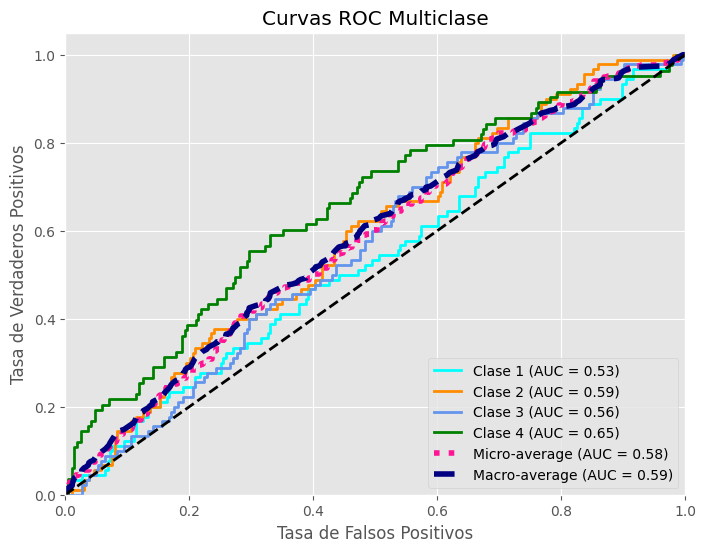

In [132]:
# --- 3. Calcula FPR, TPR y AUC para cada clase ---
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, c in enumerate(classes):
    fpr[i], tpr[i], _   = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i]          = auc(fpr[i], tpr[i])

# --- 4. Micro-average y Macro-average ---
# Micro-average (trata todas las muestras juntas)
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true_bin.ravel(),
    y_score.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average (promedia las curvas de cada clase)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- 5. Dibuja las curvas ROC ---
plt.figure(figsize=(8, 6))

# Curvas por clase
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(len(classes)), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f'Clase {classes[i]} (AUC = {roc_auc[i]:0.2f})'
    )

# Curvas micro y macro
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f'Micro-average (AUC = {roc_auc["micro"]:0.2f})',
    color='deeppink', linestyle=':', linewidth=4
)
plt.plot(
    fpr["macro"], tpr["macro"],
    label=f'Macro-average (AUC = {roc_auc["macro"]:0.2f})',
    color='navy', linestyle='--', linewidth=4
)

# Línea de referencia aleatoria
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Ajustes de estilo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC Multiclase')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [133]:
#model.save("modeloBestAllQV2")